In [1]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

In [3]:
import xarray as xr 
#import xgcm 
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import glob
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mticker
import cartopy
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
now = datetime.now()


path_data_out = '/data/user/aprigent/projects/uncertainty_ATL3_ABA/data/'

# List of models and scenarios

In [4]:
model_list_CMIP5=['ACCESS1-0','ACCESS1-3','bcc-csm1-1-m','bcc-csm1-1','BNU-ESM',
            'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0',
            'FGOALS-g2','GFDL-CM3','GFDL-ESM2G','GFDL-ESM2M','GISS-E2-H-CC','GISS-E2-H',
            'GISS-E2-R-CC','GISS-E2-R','HadGEM2-CC','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR',
            'MIROC-ESM-CHEM','MIROC-ESM','MIROC5','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','NorESM1-M','NorESM1-ME']

scenario_CMIP5=['rcp45','rcp85']


model_list_CMIP6=['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0',
            'CESM2-WACCM','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','INM-CM4-8',
            'INM-CM5-0','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3',
            'NorESM2-LM','NorESM2-MM']

scenario_CMIP6=['ssp245','ssp585']
model_all = np.hstack([model_list_CMIP5,model_list_CMIP6])


path_fig='/data/user/aprigent/projects/uncertainty_ATL3_ABA/figures/'
path_data_out = '/data/user/aprigent/projects/uncertainty_ATL3_ABA/data/'



In [5]:
running_mean_atl3_tmp_cmip5 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP5.nc')
running_mean_atl3_tmp_cmip5['scenario'] = scenario_CMIP6
running_mean_atl3_tmp_cmip6 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP6.nc')

running_mean_atl3_tmp = xr.concat([running_mean_atl3_tmp_cmip5,running_mean_atl3_tmp_cmip6],dim='model')

running_mean_atl3 = running_mean_atl3_tmp.sel(time=slice(datetime(1900, 1, 1),datetime(2085, 12, 31)))

In [6]:
X = np.arange(0,running_mean_atl3.amp_ATL3.shape[2],1)
Xf_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for i in range(Xf_tmp.shape[0]):
    for j in range(Xf_tmp.shape[1]):
        Y = running_mean_atl3.amp_ATL3[i,j,:]
        p2 = np.polyfit(X,Y,deg=2)
        p3 = np.polyfit(X,Y,deg=3)
        p4 = np.polyfit(X,Y,deg=4)
        p5 = np.polyfit(X,Y,deg=5)

        Xf_n2 = np.polyval(p2,X)
        Xf_n3 = np.polyval(p3,X)
        Xf_n4 = np.polyval(p4,X)
        Xf_n5 = np.polyval(p5,X)

        Xf_tmp[i,j,:] = Xf_n2
Xf = xr.Dataset({'Xf': (['scenario','model','time'], Xf_tmp),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_all),
                              'time':running_mean_atl3.time} )

# Compute $\epsilon$(s,m,t)

$\epsilon$(s,m,t) = X(s,m,t) - X$_{f}$(s,m,t)

In [7]:
epsilon_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for j in range(epsilon_tmp.shape[0]):
    for i in range(epsilon_tmp.shape[1]):
        epsilon_tmp[j,i,:] = running_mean_atl3.amp_ATL3[j,i,:] - Xf.Xf[j,i,:]
        
        
epsilon = xr.Dataset({'eps': (['scenario','model','time'], epsilon_tmp),
                               },
                      coords={'scenario': np.array(running_mean_atl3.scenario.values),
                              'model': np.array(running_mean_atl3.model.values),
                              'time':running_mean_atl3.time} )

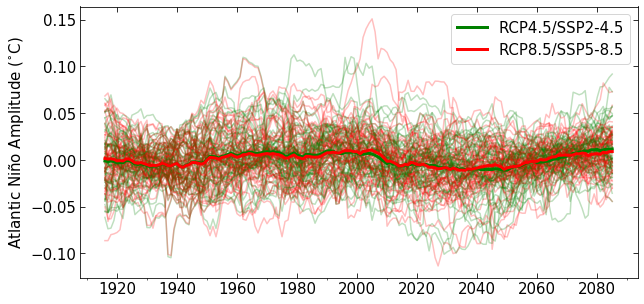

In [8]:
f,ax = plt.subplots(1,1,figsize=[10,5])
ftz=15
eps_ssp245 = np.nanmean(epsilon.eps[0,:,:],0)
eps_ssp585 = np.nanmean(epsilon.eps[1,:,:],0)



for i in range(epsilon.eps.shape[1]):
    ax.plot(epsilon.time,epsilon.eps[0,i,:],color='green',alpha=0.25)
    ax.plot(epsilon.time,epsilon.eps[1,i,:],color='red',alpha=0.25)

    
ax.plot(epsilon.time,eps_ssp245,color='green',linewidth=3,label='RCP4.5/SSP2-4.5')
ax.plot(epsilon.time,eps_ssp585,color='red',linewidth=3,label='RCP8.5/SSP5-8.5')

ax.legend(fontsize=ftz)

years = mdates.YearLocator(20)   # every 5 years
years_minor = mdates.YearLocator(10)  # every year
myFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(years_minor)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params(labelsize=ftz)
ax.set_ylabel(r'Atlantic Niño Amplitude ($^{\circ}$C)',fontsize=ftz)

ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True,length=5,direction='in')


plt.savefig(path_fig + 'figure_S2_internal_variability_ATL3.png',
             dpi = 300,
            bbox_inches='tight')